In [1]:
%matplotlib inline


# Using weights in blocked reduction

Sometimes data has outliers or less reliable points that might skew a blocked
mean or even a median. If the reduction function can take a ``weights``
argument, like ``numpy.average``, you can pass in weights to
:class:`verde.BlockReduce` to lower the influence of the offending data points.
However, :class:`verde.BlockReduce` can't produce weights for the blocked data
(for use by a gridder, for example). If you want to produced blocked weights as
well, use :class:`verde.BlockMean`.


Index of outliers: [1608 2347 1099 2408  674  433 1071 2452  124 1219 1126  938  875   51
 2407  892  255 1349 1112 1326]


/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


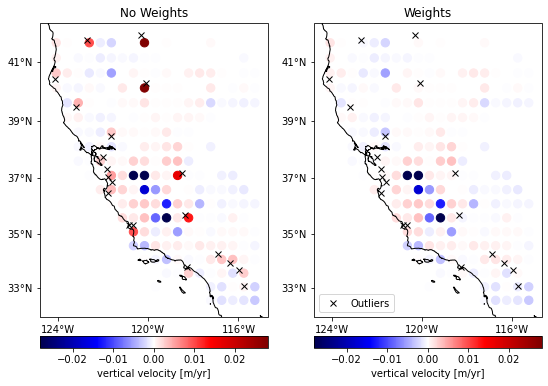

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import verde as vd

# We'll test this on the California vertical GPS velocity data
data = vd.datasets.fetch_california_gps()

# We'll add some random extreme outliers to the data
outliers = np.random.RandomState(2).randint(0, data.shape[0], size=20)
data.velocity_up[outliers] += 0.08
print("Index of outliers:", outliers)

# Create an array of weights and set the weights for the outliers to a very low
# value
weights = np.ones_like(data.velocity_up)
weights[outliers] = 1e-5

# Now we can block average the points with and without weights to compare the
# outputs.
reducer = vd.BlockReduce(reduction=np.average, spacing=30 / 60, center_coordinates=True)
coordinates, no_weights = reducer.filter(
    (data.longitude, data.latitude), data.velocity_up
)
__, with_weights = reducer.filter(
    (data.longitude, data.latitude), data.velocity_up, weights
)

# Now we can plot the data sets side by side on Mercator maps
fig, axes = plt.subplots(
    1, 2, figsize=(9, 7), subplot_kw=dict(projection=ccrs.Mercator())
)
titles = ["No Weights", "Weights"]
crs = ccrs.PlateCarree()
maxabs = vd.maxabs(data.velocity_up)
for ax, title, velocity in zip(axes, titles, (no_weights, with_weights)):
    ax.set_title(title)
    # Plot the locations of the outliers
    ax.plot(
        data.longitude[outliers],
        data.latitude[outliers],
        "xk",
        transform=crs,
        label="Outliers",
    )
    # Plot the block means and saturate the colorbar a bit to better show the
    # differences in the data.
    pc = ax.scatter(
        *coordinates,
        c=velocity,
        s=70,
        transform=crs,
        cmap="seismic",
        vmin=-maxabs / 3,
        vmax=maxabs / 3
    )
    cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
    cb.set_label("vertical velocity [m/yr]")
    vd.datasets.setup_california_gps_map(ax)
ax.legend(loc="lower left")
plt.show()